# Transformacija i Agregacija Podataka za Seaborn

## Seminarski rad - Seaborn
---

### **Što ćemo naučiti:**

U ovom notebook-u ćemo istražiti **napredne tehnike transformacije podataka** specifične za Seaborn vizualizaciju:

1. **🔄 Data Transformation** - Preparing podataka za optimalne grafikone
2. **📊 Aggregation Functions** - Sumiranje podataka za insights
3. **🎯 Groupby Operations** - Kombinovanje sa Seaborn funkcijama
4. **📈 Statistical Transformations** - Log scale, normalization, binning
5. **🔗 Multi-level Data** - Hierarchical indexing za complex visualizations

### **Zašto je ovo važno:**
- Raw podaci retko su spremni za vizualizaciju
- Transformacija može otkriti skrivene patterns
- Agregacija omogućava high-level insights
- Dobra priprema = bolje grafikone

---

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import warnings

# Podešavanje
sns.set_theme()
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)

# Učitavanje početnih podataka
flights = sns.load_dataset('flights')
tips = sns.load_dataset('tips')
penguins = sns.load_dataset('penguins').dropna()

print(f"📊 UČITANI PODACI:")
print(f"Flights: {flights.shape} - airlines passenger data")
print(f"Tips: {tips.shape} - restaurant tips data")
print(f"Penguins: {penguins.shape} - penguin measurements")

📊 UČITANI PODACI:
Flights: (144, 3) - airlines passenger data
Tips: (244, 7) - restaurant tips data
Penguins: (333, 7) - penguin measurements


### 1. **Agregacija podataka za vizualizaciju**

Seaborn često automatski agregira podatke, ali **eksplicitna agregacija** nam daje:
- **Potpunu kontrolu** nad kako podaci su sumirani
- **Performance benefits** za velike datasets
- **Cleaner data** za complex visualizations

**Ključne pandas agregacije:**
- `groupby().agg()` - Flexible aggregation
- `pivot_table()` - Cross-tabulation with aggregation
- `resample()` - Time-based aggregation
- `cut()` / `qcut()` - Binning continuous variables

Yearly flight statistics:
      count   sum   mean   std  min  max
year                                    
1949     12  1520  126.7  13.7  104  148
1950     12  1676  139.7  19.1  114  170
1951     12  2042  170.2  18.4  145  199
1952     12  2364  197.0  23.0  171  242
1953     12  2700  225.0  28.5  180  272
1954     12  2867  238.9  34.9  188  302
1955     12  3408  284.0  42.1  233  364
1956     12  3939  328.2  47.9  271  413
1957     12  4421  368.4  57.9  301  467
1958     12  4572  381.0  64.5  310  505
1959     12  5140  428.3  69.8  342  559
1960     12  5714  476.2  77.7  390  622



Monthly stats shape: (144, 4)
   year month  total_passengers  growth_rate_pct
0  1949   Jan               112              NaN
1  1949   Feb               118         5.357143

Pivot table shape: (12, 12)
Pivot table sample:
year   1949  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  1960
month                                                                        
Jan     112   115   145   171   196   204   242   284   315   340   360   417
Feb     118   126   150   180   196   188   233   277   301   318   342   391


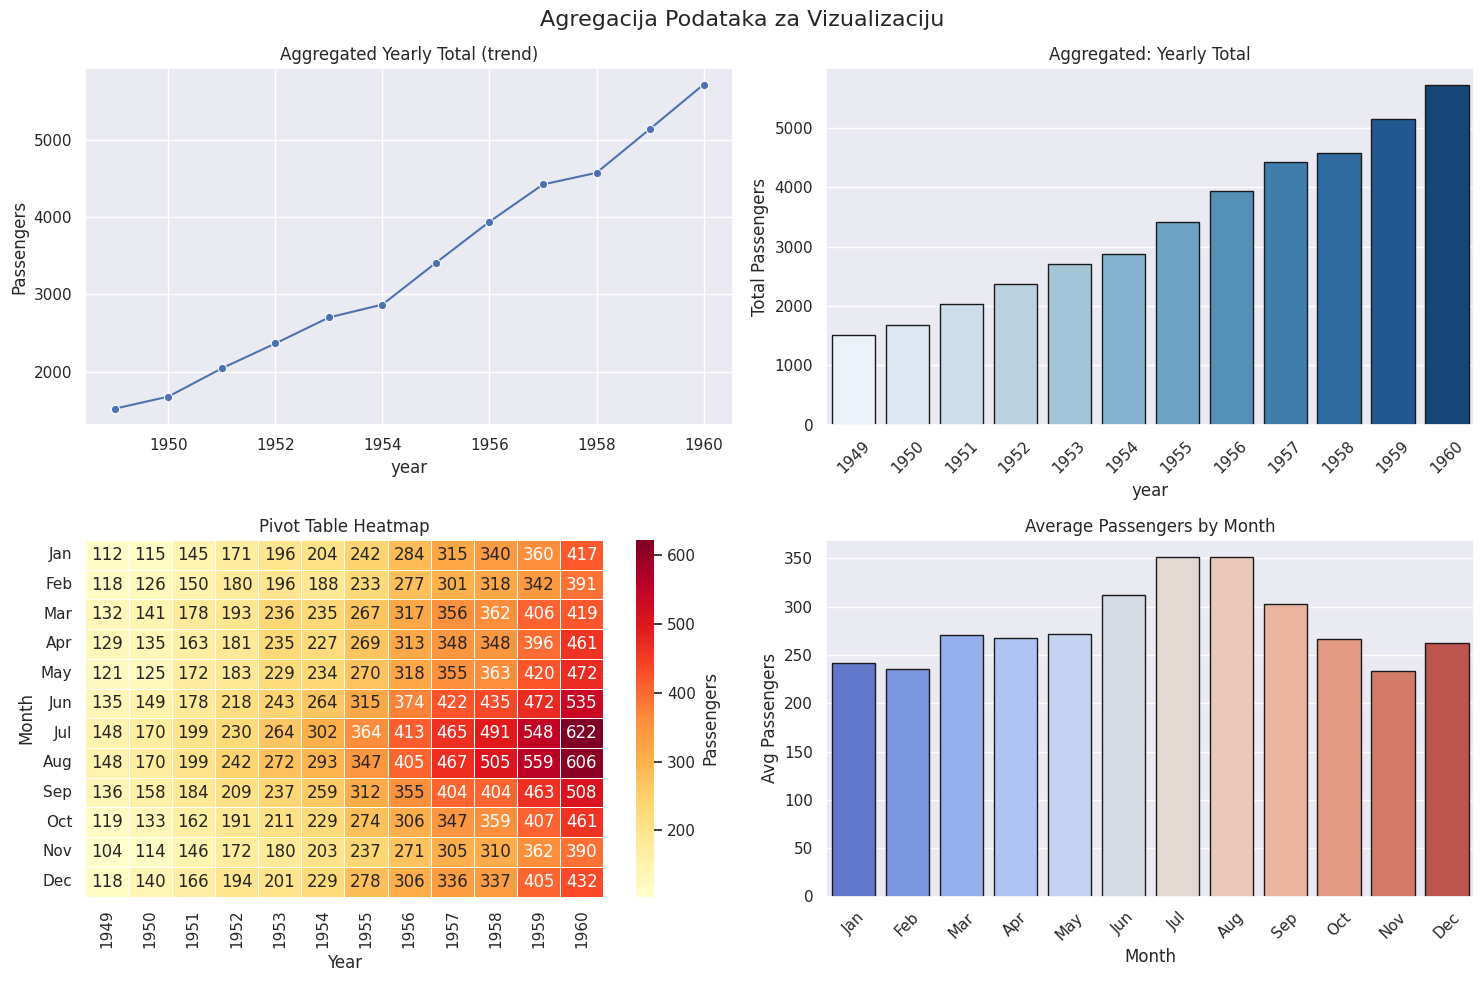


🔍 INSIGHTS FROM AGGREGATION:
Najprometnije godina: 1960 (5714 putnika)
Najprometnije mesec: Jul
Prosečni rast po godini: 12.9%


In [2]:
yearly_flights = flights.groupby('year')['passengers'].agg([
    'count',    # broj meseci
    'sum',      # ukupni putnici
    'mean',     # prosečni mesečni putnici
    'std',      # standardna devijacija
    'min',      # najmanji broj
    'max'       # najveći broj
])

print("Yearly flight statistics:")
print(yearly_flights.round(1))

# Multi-level aggregation (compute pct_change on the sorted time series first)
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
flights_sorted = flights.copy()
# ensure month is categorical so sorting keeps calendar order
flights_sorted['month'] = pd.Categorical(flights_sorted['month'], categories=month_order, ordered=True)
flights_sorted = flights_sorted.sort_values(['year','month']).reset_index(drop=True)
# pct_change on the full time series (month-over-month)
flights_sorted['pct_change'] = flights_sorted['passengers'].pct_change() * 100

monthly_stats = flights_sorted.groupby(['year','month']).agg(
    total_passengers=('passengers','sum'),
    growth_rate_pct=('pct_change','mean')
).reset_index()

print(f"\nMonthly stats shape: {monthly_stats.shape}")
print(monthly_stats.head(2))

# Pivot table aggregation (ensure months are in calendar order)
pivot_flights = flights.pivot_table(
    values='passengers',
    index='month', 
    columns='year', 
    aggfunc='sum'
).reindex(month_order)

print(f"\nPivot table shape: {pivot_flights.shape}")
print("Pivot table sample:")
print(pivot_flights.head(2))

# Kreiranje grafika sa aggregated podacima
plt.close('all')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Agregacija Podataka za Vizualizaciju', fontsize=16)

# 1. Yearly trends sa original vs aggregated (plot aggregated yearly sums as line to avoid overplotting)
yearly_sum = flights.groupby('year')['passengers'].sum().reset_index()
sns.lineplot(data=yearly_sum, x='year', y='passengers', marker='o', ax=axes[0,0])
axes[0,0].set_title('Aggregated Yearly Total (trend)')
axes[0,0].set_ylabel('Passengers')

# 2. Agregirana godišnja suma - barplot
sns.barplot(data=yearly_sum, x='year', y='passengers', ax=axes[0,1], palette='Blues', edgecolor='k')
axes[0,1].set_title('Aggregated: Yearly Total')
axes[0,1].set_ylabel('Total Passengers')
for tick in axes[0,1].get_xticklabels():
    tick.set_rotation(45)

# 3. Heatmap sa pivot table (annotate, linewidths)
sns.heatmap(pivot_flights, cmap='YlOrRd', ax=axes[1,0], annot=True, fmt='.0f', linewidths=0.5, linecolor='white', cbar_kws={'label':'Passengers'})
axes[1,0].set_title('Pivot Table Heatmap')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Month')

# 4. Statistical summary - average passengers by month (ordered)
monthly_means = flights.groupby('month')['passengers'].mean().reindex(month_order)
sns.barplot(x=monthly_means.index, y=monthly_means.values, ax=axes[1,1], palette='coolwarm', edgecolor='k')
axes[1,1].set_title('Average Passengers by Month')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Avg Passengers')
for tick in axes[1,1].get_xticklabels():
    tick.set_rotation(45)

plt.tight_layout()
plt.show()

print("\n🔍 INSIGHTS FROM AGGREGATION:")
most_busy_year = int(yearly_sum.loc[yearly_sum['passengers'].idxmax(), 'year'])
most_busy_year_val = int(yearly_sum['passengers'].max())
most_busy_month = monthly_means.idxmax()
avg_yearly_growth = yearly_flights['sum'].pct_change().mean() * 100
print(f"Najprometnije godina: {most_busy_year} ({most_busy_year_val} putnika)")
print(f"Najprometnije mesec: {most_busy_month}")
print(f"Prosečni rast po godini: {avg_yearly_growth:.1f}%")

### 2. **Statistical Transformations**

**Transformacije** menjaju distribuciju podataka da bi:
- **Normalizovali skewed data**
- **Smanjili impact outliera**
- **Linearizovali relationships**
- **Standardizovali scales**

**Česte transformacije:**
- **Log transformation** - za positively skewed data
- **Square root** - umanjuje skewness
- **Standardization (z-score)** - mean=0, std=1
- **Min-Max scaling** - scale to [0,1] range
- **Quantile binning** - convert continuous to categorical

Original data shape: (1000, 8)
Transformation statistics:
       original  log_transformed  sqrt_transformed  standardized  \
count  1000.000         1000.000          1000.000      1000.000   
mean      1.945            0.904             1.232        -0.000   
std       1.945            0.576             0.653         1.001   
min       0.009            0.009             0.096        -0.996   
25%       0.538            0.431             0.734        -0.724   
50%       1.374            0.864             1.172        -0.294   
75%       2.728            1.316             1.652         0.403   
max      16.345            2.853             4.043         7.407   

       minmax_scaled  
count       1000.000  
mean           0.118  
std            0.119  
min            0.000  
25%            0.032  
50%            0.084  
75%            0.166  
max            1.000  


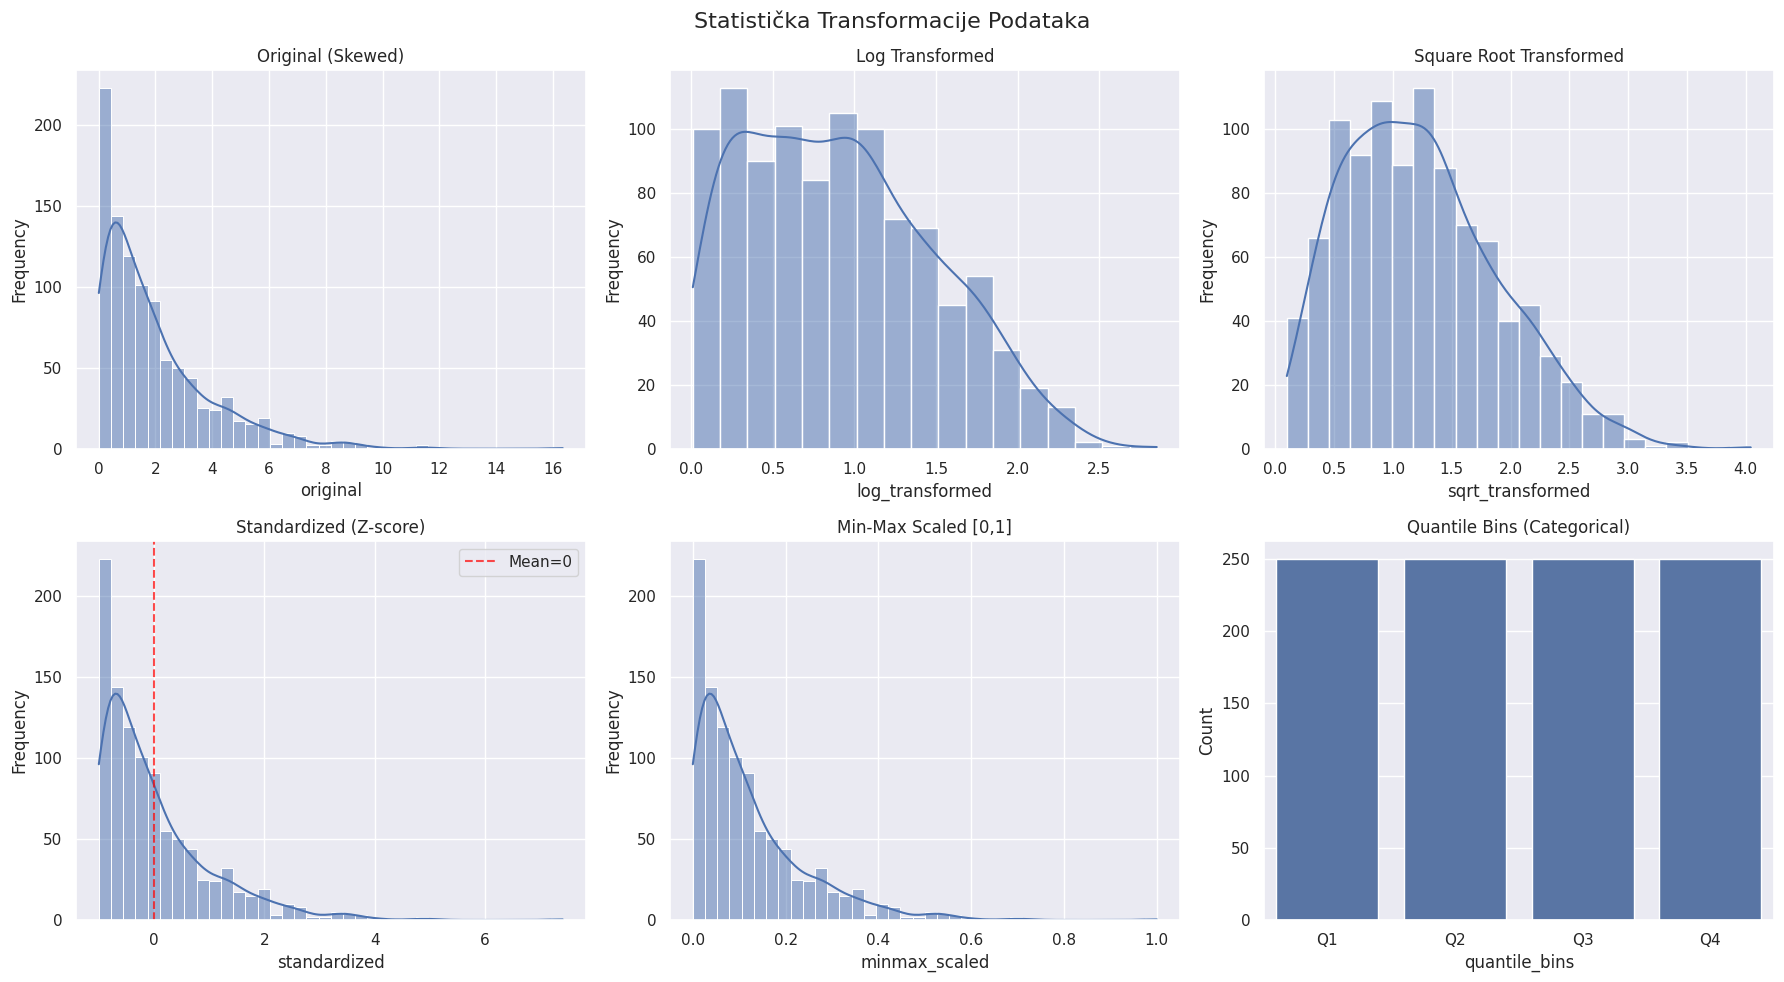


📈 IMPACT ON VISUALIZATION:


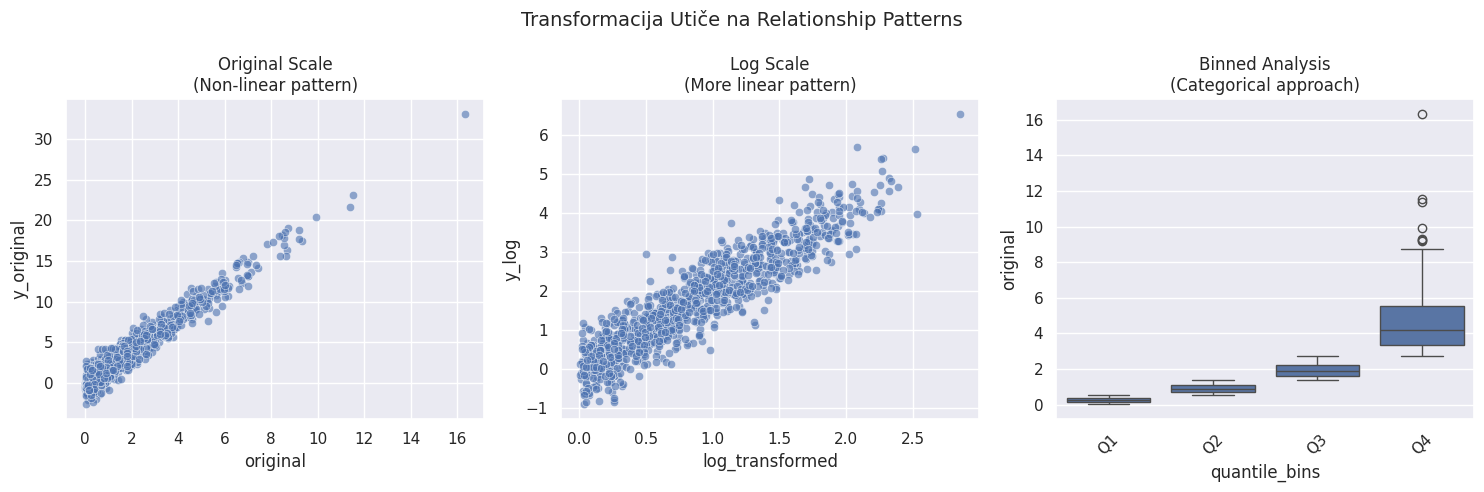


📊 SKEWNESS COMPARISON:
original          :  1.865 (Highly skewed)
log_transformed   :  0.428 (Symmetric)
sqrt_transformed  :  0.598 (Moderately skewed)
standardized      :  1.865 (Highly skewed)

✅ BEST PRACTICES:
- Log transform za positively skewed data
- Standardization za machine learning
- Min-max scaling za neural networks
- Binning za interpretability


In [3]:
np.random.seed(42)
n = 1000
skewed_data = pd.DataFrame({
    'original': np.random.exponential(2, n),  # Positively skewed
    'group': np.random.choice(['A', 'B', 'C'], n)
})

# Primenjujemo različite transformacije
skewed_data['log_transformed'] = np.log1p(skewed_data['original'])  # log(1+x)
skewed_data['sqrt_transformed'] = np.sqrt(skewed_data['original'])
skewed_data['standardized'] = stats.zscore(skewed_data['original'])
skewed_data['minmax_scaled'] = ((skewed_data['original'] - skewed_data['original'].min()) / 
                                (skewed_data['original'].max() - skewed_data['original'].min()))

# Binning za kategorijsku transformaciju
skewed_data['quantile_bins'] = pd.qcut(skewed_data['original'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
skewed_data['equal_bins'] = pd.cut(skewed_data['original'], bins=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

print(f"Original data shape: {skewed_data.shape}")
print("Transformation statistics:")
transformation_stats = skewed_data[[
    'original', 'log_transformed', 'sqrt_transformed', 'standardized', 'minmax_scaled'
]].describe()
print(transformation_stats.round(3))

# Vizualizacija transformacija
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Statistička Transformacije Podataka', fontsize=16)

# 1. Original distribution
sns.histplot(data=skewed_data, x='original', kde=True, ax=axes[0,0])
axes[0,0].set_title('Original (Skewed)')
axes[0,0].set_ylabel('Frequency')

# 2. Log transformation
sns.histplot(data=skewed_data, x='log_transformed', kde=True, ax=axes[0,1])
axes[0,1].set_title('Log Transformed')
axes[0,1].set_ylabel('Frequency')

# 3. Square root transformation
sns.histplot(data=skewed_data, x='sqrt_transformed', kde=True, ax=axes[0,2])
axes[0,2].set_title('Square Root Transformed')
axes[0,2].set_ylabel('Frequency')

# 4. Standardized (z-score)
sns.histplot(data=skewed_data, x='standardized', kde=True, ax=axes[1,0])
axes[1,0].set_title('Standardized (Z-score)')
axes[1,0].axvline(0, color='red', linestyle='--', alpha=0.7, label='Mean=0')
axes[1,0].legend()
axes[1,0].set_ylabel('Frequency')

# 5. Min-Max scaled
sns.histplot(data=skewed_data, x='minmax_scaled', kde=True, ax=axes[1,1])
axes[1,1].set_title('Min-Max Scaled [0,1]')
axes[1,1].set_ylabel('Frequency')

# 6. Binned data
sns.countplot(data=skewed_data, x='quantile_bins', ax=axes[1,2])
axes[1,2].set_title('Quantile Bins (Categorical)')
axes[1,2].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Demonstracija uticaja transformacije na visualization
print("\n📈 IMPACT ON VISUALIZATION:")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transformacija Utiče na Relationship Patterns', fontsize=14)

# Kreiranje corelated varijable
skewed_data['y_original'] = skewed_data['original'] * 2 + np.random.normal(0, 1, n)
skewed_data['y_log'] = skewed_data['log_transformed'] * 2 + np.random.normal(0, 0.5, n)

# Original scale relationship
sns.scatterplot(data=skewed_data, x='original', y='y_original', alpha=0.6, ax=axes[0])
axes[0].set_title('Original Scale\n(Non-linear pattern)')

# Log scale relationship
sns.scatterplot(data=skewed_data, x='log_transformed', y='y_log', alpha=0.6, ax=axes[1])
axes[1].set_title('Log Scale\n(More linear pattern)')

# Binned relationship
sns.boxplot(data=skewed_data, x='quantile_bins', y='original', ax=axes[2])
axes[2].set_title('Binned Analysis\n(Categorical approach)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Skewness analysis
transformations = ['original', 'log_transformed', 'sqrt_transformed', 'standardized']
skewness_results = {}

for col in transformations:
    skew_val = stats.skew(skewed_data[col])
    skewness_results[col] = skew_val

print("\n📊 SKEWNESS COMPARISON:")
for transform, skew_val in skewness_results.items():
    interpretation = "Symmetric" if abs(skew_val) < 0.5 else "Moderately skewed" if abs(skew_val) < 1 else "Highly skewed"
    print(f"{transform:18}: {skew_val:6.3f} ({interpretation})")

print("\n✅ BEST PRACTICES:")
print("- Log transform za positively skewed data")
print("- Standardization za machine learning")
print("- Min-max scaling za neural networks")
print("- Binning za interpretability")

### 3. **Advanced Groupby Operations**

Kombinovanje **pandas groupby** sa **Seaborn** omogućava:
- **Custom aggregation functions**
- **Multiple statistics** u jednom koraku
- **Conditional aggregations**
- **Time-based grouping**

**Advanced techniques:**
- `transform()` - keeps original shape
- `apply()` - custom functions per group
- `agg()` with dictionaries - multiple functions
- `filter()` - filter entire groups
- `resample()` - time-based aggregation

Enhanced tips dataset: (244, 10)
New columns: ['tip_percentage', 'bill_category', 'party_size_group']

Custom statistics by day:
      count   mean   std    min    max  range   iqr     cv
day                                                       
Thur   62.0  16.13  3.87   7.30  26.63  19.34  5.45  23.97
Fri    19.0  16.99  4.77  10.36  26.35  15.99  6.29  28.05
Sat    87.0  15.32  5.13   3.56  32.57  29.01  6.44  33.49
Sun    76.0  16.69  8.47   5.94  71.03  65.09  6.79  50.77
Multi-aggregation result shape: (8, 12)
Sample columns: ['day', 'time', 'total_bill_count', 'total_bill_mean', 'total_bill_sum', 'tip_mean', 'tip_std', 'tip_max']

Conditional aggregation shape: (8, 6)
    day    time  high_tippers_count  high_tippers_pct  avg_bill_high_tippers  \
0  Thur   Lunch                10.0         16.393443                 16.537   
1  Thur  Dinner                 0.0          0.000000                    NaN   
2   Fri   Lunch                 2.0         28.571429                 11.00

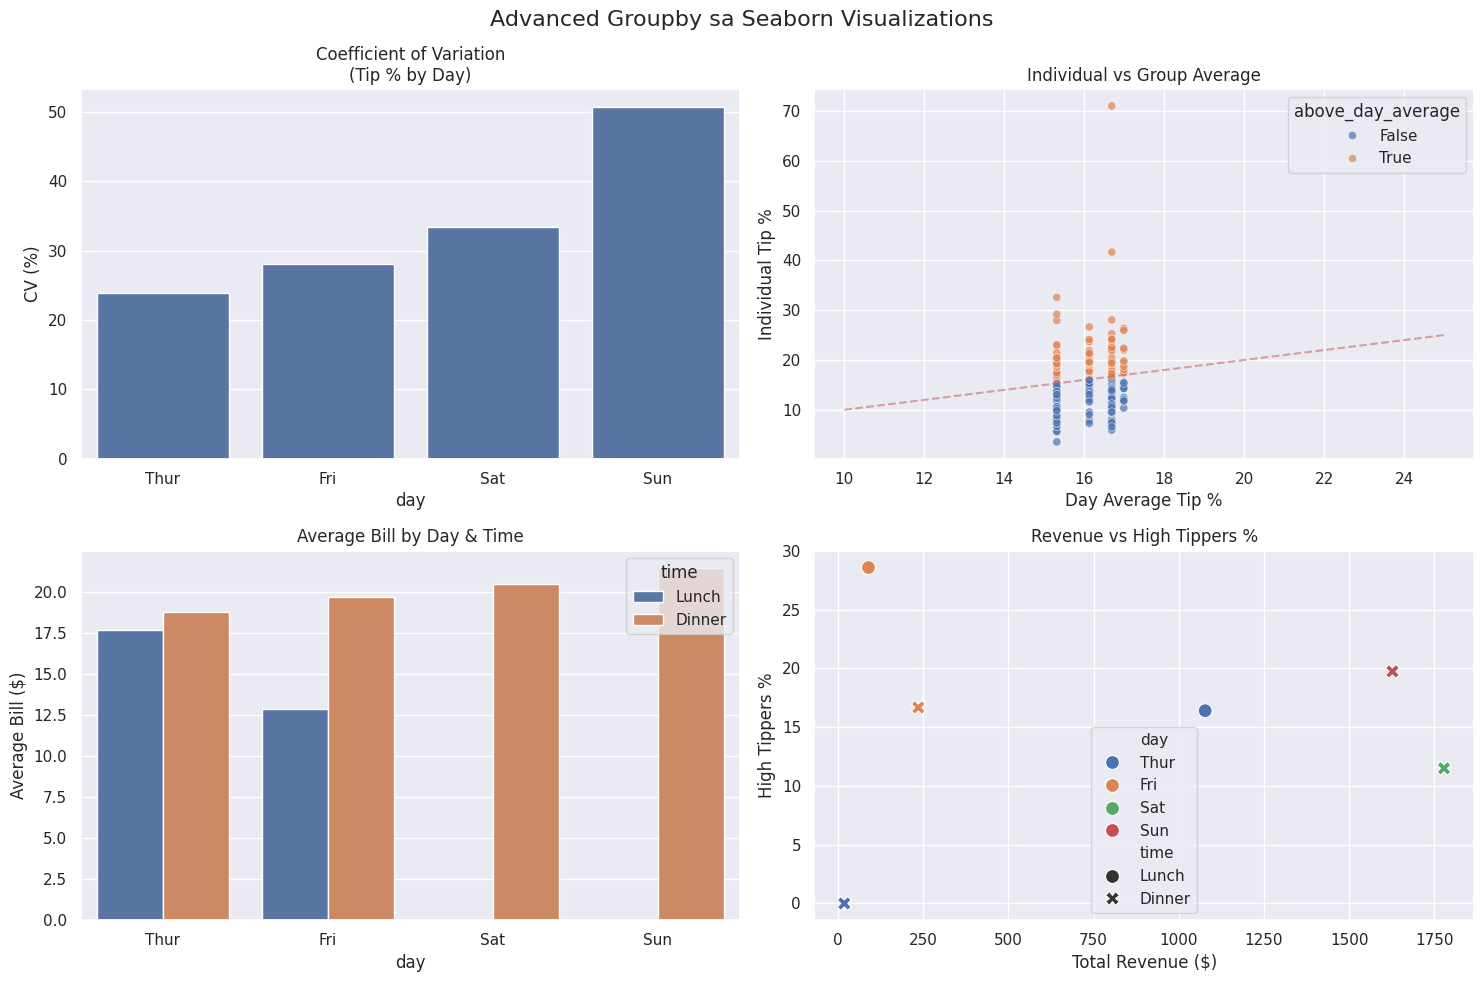


🔍 FILTER RESULTS:
Original dataset: 244 records
High volume days only: 225 records
Filtered out days with <50 customers

💡 ADVANCED GROUPBY INSIGHTS:
Najvarijabilniji dan (CV): Sun
Procenat ljudi što daju tip >20%: 16.0%
Dan sa najviše high tippers: Fri


In [4]:
tips_enhanced = tips.copy()
tips_enhanced['tip_percentage'] = (tips_enhanced['tip'] / tips_enhanced['total_bill']) * 100
tips_enhanced['bill_category'] = pd.cut(tips_enhanced['total_bill'], 
                                       bins=[0, 15, 25, 50], 
                                       labels=['Small', 'Medium', 'Large'])
tips_enhanced['party_size_group'] = tips_enhanced['size'].apply(
    lambda x: 'Solo/Pair' if x <= 2 else 'Small Group' if x <= 4 else 'Large Group'
)

print(f"Enhanced tips dataset: {tips_enhanced.shape}")
print(f"New columns: {list(tips_enhanced.columns[-3:])}")

# 1. CUSTOM AGGREGATION FUNCTIONS
def custom_stats(series):
    return pd.Series({
        'count': len(series),
        'mean': series.mean(),
        'std': series.std(),
        'min': series.min(),
        'max': series.max(),
        'range': series.max() - series.min(),
        'iqr': series.quantile(0.75) - series.quantile(0.25),
        'cv': (series.std() / series.mean()) * 100  # Coefficient of variation
    })


day_stats = tips_enhanced.groupby('day')['tip_percentage'].apply(custom_stats).unstack()
print("\nCustom statistics by day:")
print(day_stats.round(2))

# 2. MULTIPLE AGGREGATIONS sa različitim funkcijama
def _safe_mode(series):
    m = series.mode()
    return m.iloc[0] if not m.empty else np.nan

multi_agg = tips_enhanced.groupby(['day', 'time']).agg(
    total_bill_count=('total_bill', 'count'),
    total_bill_mean=('total_bill', 'mean'),
    total_bill_sum=('total_bill', 'sum'),
    tip_mean=('tip', 'mean'),
    tip_std=('tip', 'std'),
    tip_max=('tip', 'max'),
    tip_median=('tip_percentage', 'median'),
    tip_pct90=('tip_percentage', lambda x: x.quantile(0.9)),
    size_mean=('size', 'mean'),
    size_mode=('size', _safe_mode)
).reset_index()

print(f"Multi-aggregation result shape: {multi_agg.shape}")
print("Sample columns:", list(multi_agg.columns[:8]))

# 3. TRANSFORM - dodaje agregaciju u original dataset
tips_enhanced['day_avg_tip_pct'] = tips_enhanced.groupby('day')['tip_percentage'].transform('mean')
tips_enhanced['above_day_average'] = tips_enhanced['tip_percentage'] > tips_enhanced['day_avg_tip_pct']

# 4. CONDITIONAL AGGREGATION
def conditional_agg(group):
    return pd.Series({
        'high_tippers_count': (group['tip_percentage'] > 20).sum(),
        'high_tippers_pct': (group['tip_percentage'] > 20).mean() * 100,
        'avg_bill_high_tippers': group[group['tip_percentage'] > 20]['total_bill'].mean(),
        'total_revenue': group['total_bill'].sum()
    })

conditional_results = tips_enhanced.groupby(['day', 'time']).apply(conditional_agg).reset_index()
print(f"\nConditional aggregation shape: {conditional_results.shape}")
print(conditional_results.head())

# Vizualizacija advanced groupby results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Advanced Groupby sa Seaborn Visualizations', fontsize=16)

# 1. Custom statistics visualization
day_stats_viz = day_stats.reset_index()
sns.barplot(data=day_stats_viz, x='day', y='cv', ax=axes[0,0])
axes[0,0].set_title('Coefficient of Variation\n(Tip % by Day)')
axes[0,0].set_ylabel('CV (%)')

# 2. Transform results - comparing individual vs group average
sns.scatterplot(data=tips_enhanced, x='day_avg_tip_pct', y='tip_percentage', 
                hue='above_day_average', alpha=0.7, ax=axes[0,1])
axes[0,1].plot([10, 25], [10, 25], 'r--', alpha=0.5)
axes[0,1].set_title('Individual vs Group Average')
axes[0,1].set_xlabel('Day Average Tip %')
axes[0,1].set_ylabel('Individual Tip %')

# 3. Multi-aggregation results
sns.barplot(data=multi_agg, x='day', y='total_bill_mean', hue='time', ax=axes[1,0])
axes[1,0].set_title('Average Bill by Day & Time')
axes[1,0].set_ylabel('Average Bill ($)')

# 4. Conditional aggregation results
sns.scatterplot(data=conditional_results, x='total_revenue', y='high_tippers_pct', 
                hue='day', style='time', s=100, ax=axes[1,1])
axes[1,1].set_title('Revenue vs High Tippers %')
axes[1,1].set_xlabel('Total Revenue ($)')
axes[1,1].set_ylabel('High Tippers %')

plt.tight_layout()
plt.show()

# Filter groups example
high_volume_days = tips_enhanced.groupby('day').filter(lambda x: len(x) > 50)
print(f"\n🔍 FILTER RESULTS:")
print(f"Original dataset: {len(tips_enhanced)} records")
print(f"High volume days only: {len(high_volume_days)} records")
print(f"Filtered out days with <50 customers")

print("\n💡 ADVANCED GROUPBY INSIGHTS:")
print(f"Najvarijabilniji dan (CV): {day_stats_viz.loc[day_stats_viz['cv'].idxmax(), 'day']}")
print(f"Procenat ljudi što daju tip >20%: {(tips_enhanced['tip_percentage'] > 20).mean()*100:.1f}%")
print(f"Dan sa najviše high tippers: {conditional_results.loc[conditional_results['high_tippers_pct'].idxmax(), 'day']}")

### 4. **Multi-level Data i Hierarchical Indexing**

**MultiIndex** (hierarchical indexing) omogućava:
- **Complex data structures** sa više nivoa grupa
- **Efficient storage** za high-dimensional data
- **Advanced slicing** i filtering
- **Sophisticated visualizations** sa Seaborn

**Use cases:**
- Time series sa multiple variables
- Geographic data sa sub-regions  
- A/B test results across segments
- Financial data (stocks, sectors, time)

Multi-level dataset shape: (144, 4)
Index levels: ['Year', 'Quarter', 'Region', 'Product']

Sample data:
                                   Sales  Units  Profit_Margin  Market_Share
Year Quarter Region Product                                                 
2022 Q1      North  Laptop   1517.199343     46       0.208073      0.173398
                    Phone    1169.283271     55       0.118030      0.201575
                    Tablet   1464.606292     55       0.289258      0.269088
             South  Laptop   1233.251068     61       0.215506      0.366003
                    Phone     743.777932     38       0.258523      0.324198

🔍 MULTI-LEVEL SLICING EXAMPLES:
2023 data shape: (48, 4)
Q4 2023 data shape: (12, 4)
Laptop sales shape: (48, 4)

Yearly totals:
Year
2022    82810.0
2023    88724.0
2024    87959.0
Name: Sales, dtype: float64

Quarterly pivot shape: (3, 4)
Quarter            Q1            Q2            Q3            Q4
Year                                              

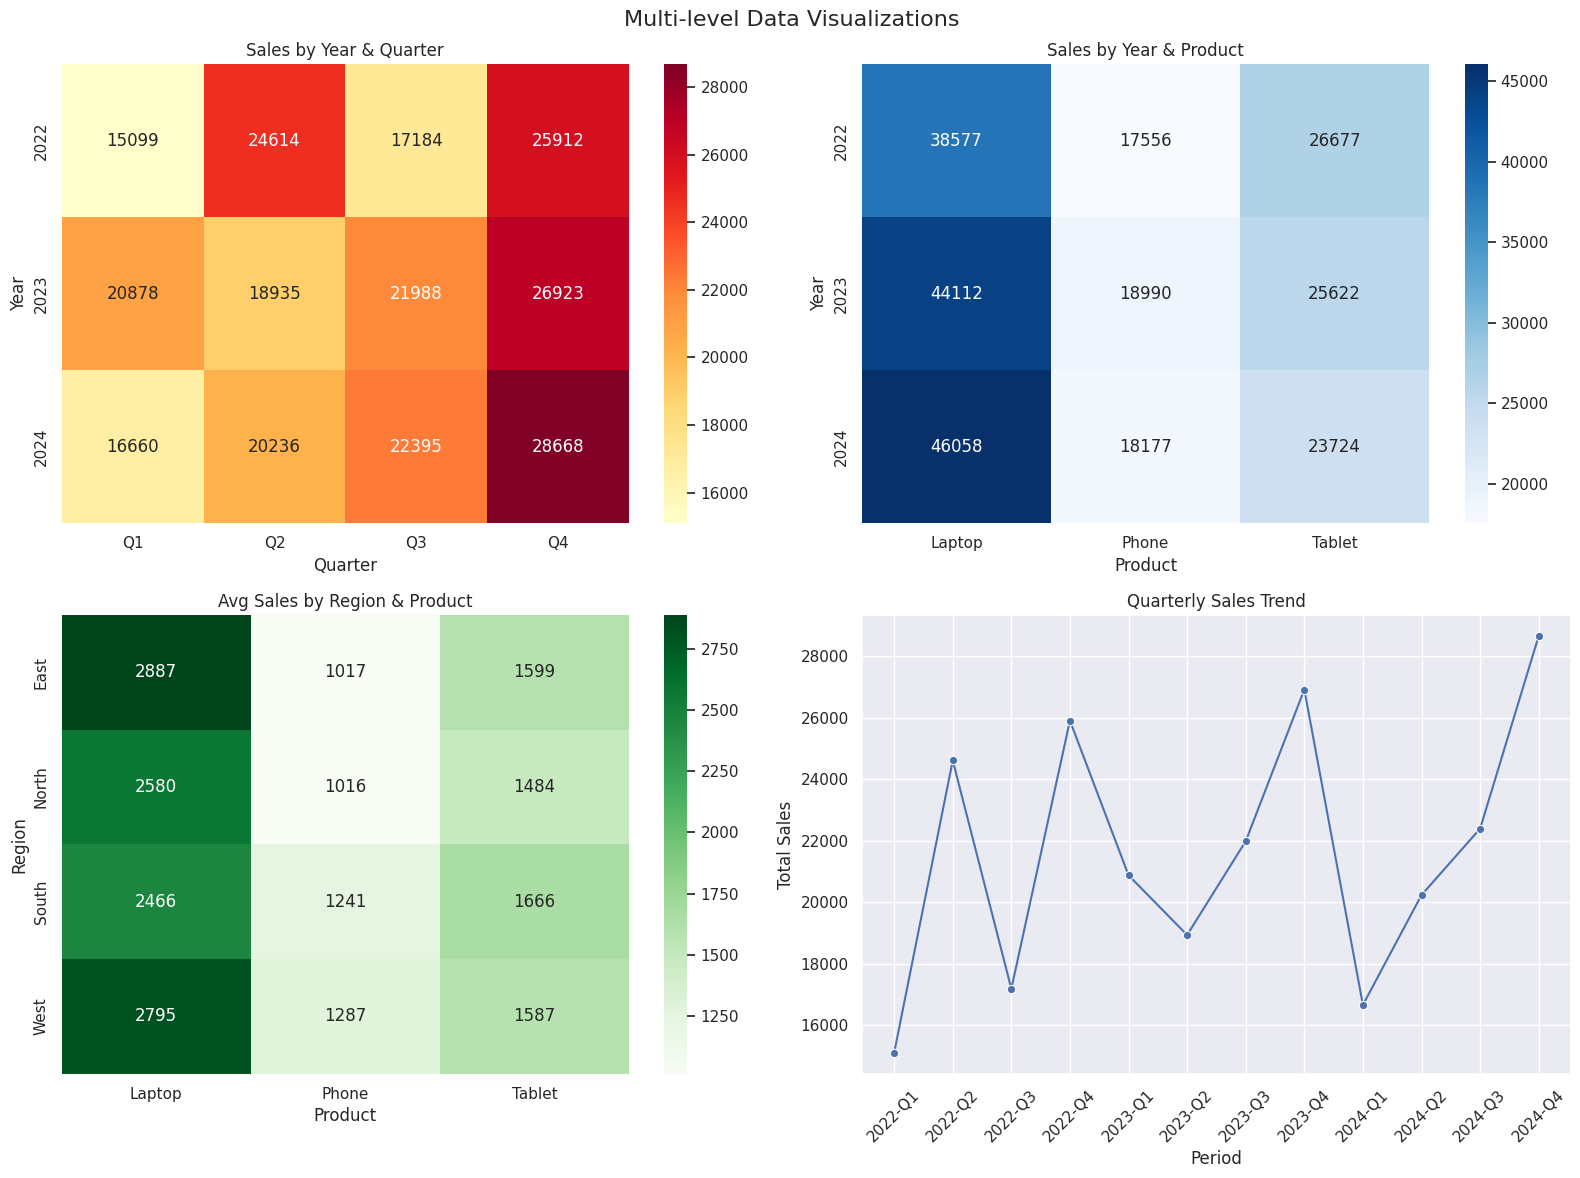


📊 ADVANCED MULTI-LEVEL ANALYSIS:
Quarterly growth rates:
Year  Quarter
2022  Q2         63.02
      Q3        -30.19
      Q4         50.79
2023  Q1        -19.43
      Q2         -9.31
      Q3         16.12
      Q4         22.45
2024  Q1        -38.12
      Q2         21.47
      Q3         10.67
      Q4         28.01
Name: Sales, dtype: float64

🏆 TOP PERFORMERS:
Best region: West
Best product: Laptop
Best quarter: Q4

Market share trends:
Year  Product
2022  Laptop     0.251
      Phone      0.266
      Tablet     0.298
2023  Laptop     0.283
      Phone      0.215
      Tablet     0.231
2024  Laptop     0.243
      Phone      0.267
      Tablet     0.262
Name: Market_Share, dtype: float64

✅ MULTI-LEVEL DATA BENEFITS:
- Efficient storage za complex hierarchical data
- Powerful slicing i dicing capabilities
- Natural groupby operations
- Easy pivoting za different views
- Perfect za business intelligence


In [5]:
np.random.seed(123)

# Simulacija business data sa multiple dimenzijama
regions = ['North', 'South', 'East', 'West']
products = ['Laptop', 'Phone', 'Tablet']
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
years = [2022, 2023, 2024]

# Kreiranje multi-index strukture
index_tuples = []
for year in years:
    for quarter in quarters:
        for region in regions:
            for product in products:
                index_tuples.append((year, quarter, region, product))

# Kreiranje MultiIndex
multi_index = pd.MultiIndex.from_tuples(
    index_tuples, 
    names=['Year', 'Quarter', 'Region', 'Product']
)

# Kreiranje podataka
n_records = len(index_tuples)
sales_data_multi = pd.DataFrame({
    'Sales': np.random.normal(1000, 300, n_records),
    'Units': np.random.poisson(50, n_records),
    'Profit_Margin': np.random.normal(0.2, 0.05, n_records),
    'Market_Share': np.random.uniform(0.1, 0.4, n_records)
}, index=multi_index)

# Dodavanje business logic
seasonal_boost = {
    'Q1': 0.9, 'Q2': 1.0, 'Q3': 1.1, 'Q4': 1.3  # Holiday boost u Q4
}

product_multiplier = {
    'Laptop': 2.5, 'Phone': 1.0, 'Tablet': 1.5  # Laptop je skuplji
}

for idx in sales_data_multi.index:
    year, quarter, region, product = idx
    sales_data_multi.loc[idx, 'Sales'] *= seasonal_boost[quarter] * product_multiplier[product]

print(f"Multi-level dataset shape: {sales_data_multi.shape}")
print(f"Index levels: {sales_data_multi.index.names}")
print("\nSample data:")
print(sales_data_multi.head())

# MULTI-LEVEL SLICING i AGGREGATION
print("\n🔍 MULTI-LEVEL SLICING EXAMPLES:")

# Slice po godini
sales_2023 = sales_data_multi.loc[2023]
print(f"2023 data shape: {sales_2023.shape}")

# Slice po godini i kvartalu
q4_2023 = sales_data_multi.loc[(2023, 'Q4')]
print(f"Q4 2023 data shape: {q4_2023.shape}")

# Cross-section
laptop_sales = sales_data_multi.xs('Laptop', level='Product')
print(f"Laptop sales shape: {laptop_sales.shape}")

# COMPLEX AGGREGATIONS sa MultiIndex
# Aggregation po različitim nivoima
yearly_totals = sales_data_multi.groupby(level='Year')['Sales'].sum()
quarterly_totals = sales_data_multi.groupby(level=['Year', 'Quarter'])['Sales'].sum()
product_totals = sales_data_multi.groupby(level=['Year', 'Product'])['Sales'].sum()
region_product = sales_data_multi.groupby(level=['Region', 'Product'])['Sales'].mean()

print(f"\nYearly totals:")
print(yearly_totals.round(0))

# UNSTACKING za visualization
quarterly_pivot = quarterly_totals.unstack(level='Quarter')
product_pivot = product_totals.unstack(level='Product')
region_product_pivot = region_product.unstack(level='Product')

print(f"\nQuarterly pivot shape: {quarterly_pivot.shape}")
print(quarterly_pivot)

# Vizualizacija multi-level podataka
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Multi-level Data Visualizations', fontsize=16)

# 1. Quarterly trends heatmap
sns.heatmap(quarterly_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[0,0])
axes[0,0].set_title('Sales by Year & Quarter')
axes[0,0].set_ylabel('Year')

# 2. Product comparison across years
sns.heatmap(product_pivot, annot=True, fmt='.0f', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Sales by Year & Product')
axes[0,1].set_ylabel('Year')

# 3. Regional product performance
sns.heatmap(region_product_pivot, annot=True, fmt='.0f', cmap='Greens', ax=axes[1,0])
axes[1,0].set_title('Avg Sales by Region & Product')
axes[1,0].set_ylabel('Region')

# 4. Time series sa reset_index za Seaborn line plot
quarterly_ts = quarterly_totals.reset_index()
quarterly_ts['Period'] = quarterly_ts['Year'].astype(str) + '-' + quarterly_ts['Quarter']
sns.lineplot(data=quarterly_ts, x='Period', y='Sales', marker='o', ax=axes[1,1])
axes[1,1].set_title('Quarterly Sales Trend')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylabel('Total Sales')

plt.tight_layout()
plt.show()

# ADVANCED MULTI-LEVEL ANALYSIS
print("\n📊 ADVANCED MULTI-LEVEL ANALYSIS:")

# Growth rates po kvartalima
growth_rates = sales_data_multi.groupby(level=['Year', 'Quarter'])['Sales'].sum().pct_change() * 100
print("Quarterly growth rates:")
print(growth_rates.dropna().round(2))

# Top performers po različitim dimenzijama
top_region = region_product_pivot.sum(axis=1).idxmax()
top_product = region_product_pivot.sum(axis=0).idxmax()
best_quarter = quarterly_pivot.sum(axis=0).idxmax()

print(f"\n🏆 TOP PERFORMERS:")
print(f"Best region: {top_region}")
print(f"Best product: {top_product}")
print(f"Best quarter: {best_quarter}")

# Market share analysis
market_share_analysis = sales_data_multi.groupby(level=['Year', 'Product'])['Market_Share'].mean()
print(f"\nMarket share trends:")
print(market_share_analysis.round(3))

print("\n✅ MULTI-LEVEL DATA BENEFITS:")
print("- Efficient storage za complex hierarchical data")
print("- Powerful slicing i dicing capabilities")
print("- Natural groupby operations")
print("- Easy pivoting za different views")
print("- Perfect za business intelligence")

### 5. **Time Series Data Transformations**

**Time series** transformacija je kritična za:
- **Trend analysis** - long-term patterns
- **Seasonality detection** - recurring patterns
- **Anomaly detection** - unusual values
- **Forecasting preparation** - stationary data

**Key transformations:**
- **Resampling** - change time frequency
- **Rolling windows** - moving averages
- **Lag features** - previous period values
- **Differencing** - remove trends
- **Seasonal decomposition** - trend + seasonal + residual

Time series data shape: (1827, 5)
Date range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00

Sample data:
                traffic    weekday  month  year  quarter
date                                                    
2020-01-01  1024.835708  Wednesday      1  2020        1
2020-01-02  1075.257893   Thursday      1  2020        1
2020-01-03  1137.852120     Friday      1  2020        1
2020-01-04  1131.499675   Saturday      1  2020        1
2020-01-05   960.845620     Sunday      1  2020        1

🔄 APPLYING TIME SERIES TRANSFORMATIONS:
Weekly average shape: (262,)
Monthly sum shape: (60,)
Quarterly max shape: (20,)

Enhanced dataset shape: (1827, 21)
New features: ['is_weekend', 'day_of_year', 'week_of_year', 'is_month_start', 'is_quarter_start']


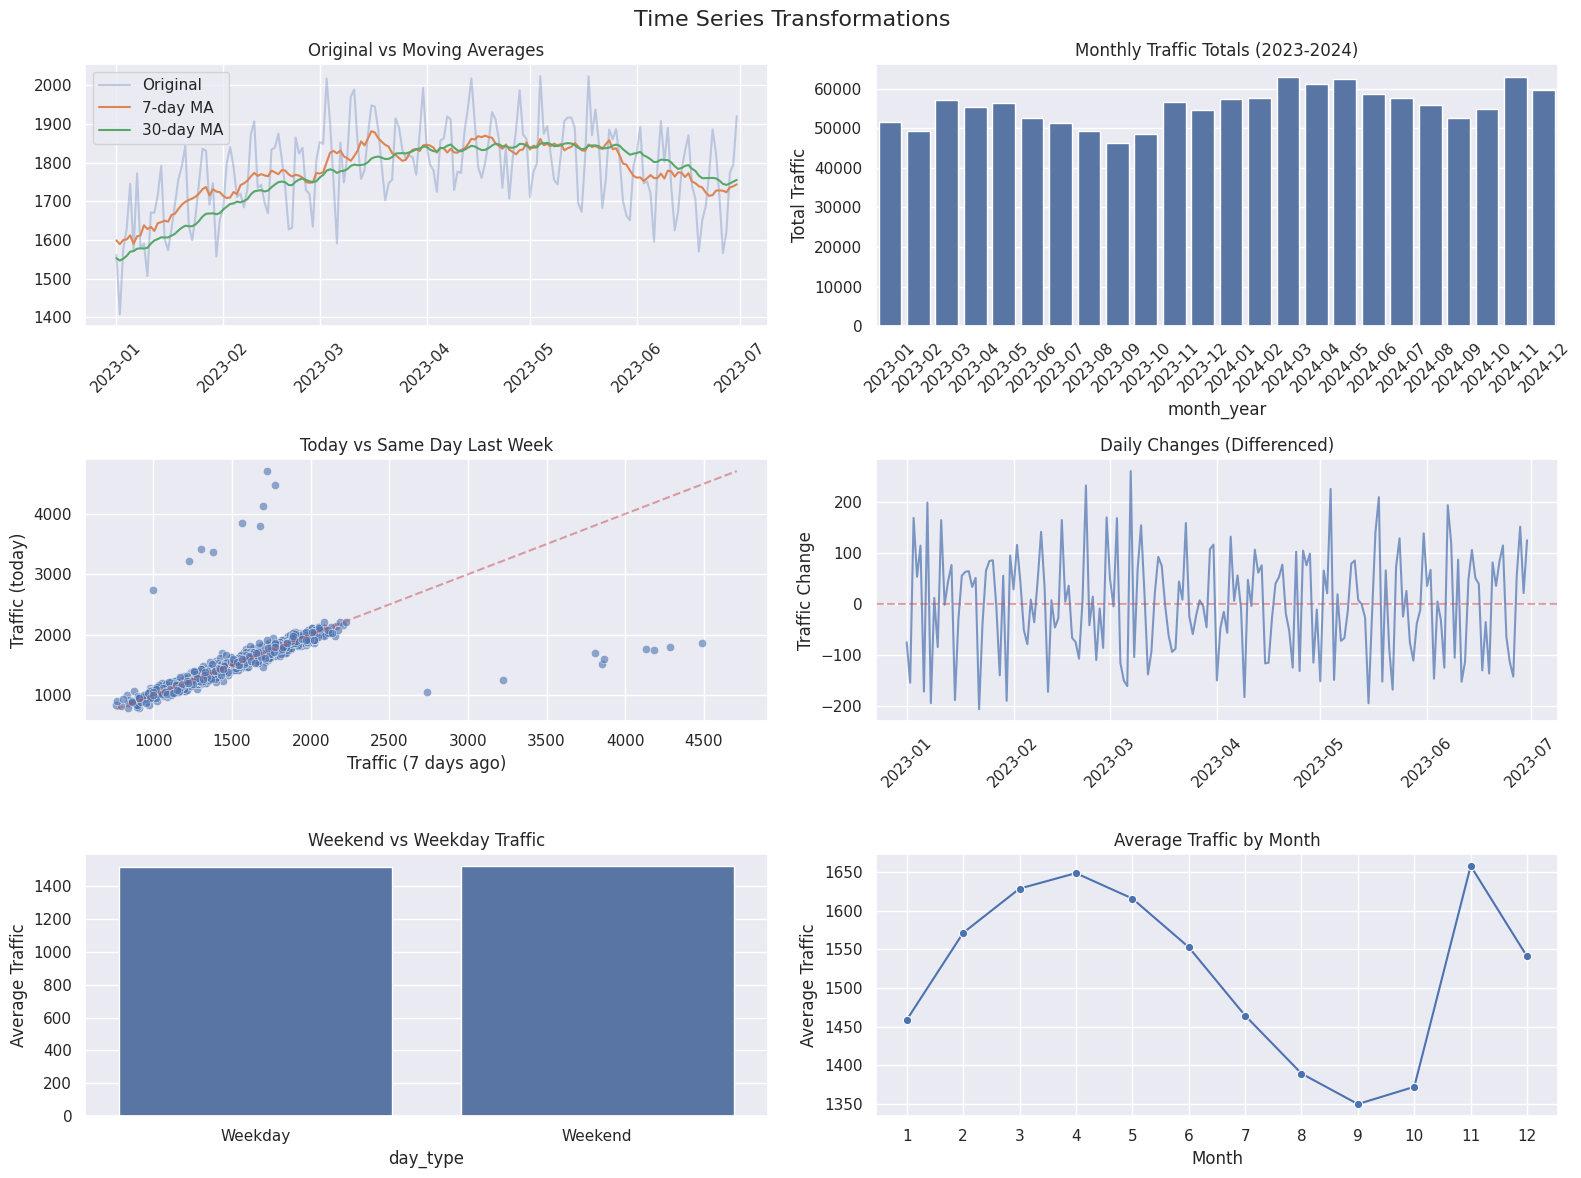


📈 TIME SERIES INSIGHTS:
7-day lag correlation: 0.687
365-day lag correlation: 0.916
Average yearly growth: 14.7%
Average 7-day volatility: 114.3
Weekend effect: +0.0%

✅ TIME SERIES TRANSFORMATION BENEFITS:
- Moving averages smooth noise
- Lag features capture temporal dependencies
- Differencing removes trends
- Resampling changes time resolution
- Custom features extract domain knowledge


In [6]:
np.random.seed(42)
date_range = pd.date_range('2020-01-01', '2024-12-31', freq='D')
n_days = len(date_range)

# Simulacija website traffic sa trendom i sezonalnošću
trend = np.linspace(1000, 2000, n_days)  # Linear growth
seasonal = 200 * np.sin(2 * np.pi * np.arange(n_days) / 365.25)  # Yearly cycle
weekly = 100 * np.sin(2 * np.pi * np.arange(n_days) / 7)  # Weekly cycle
noise = np.random.normal(0, 50, n_days)

# Kombinovanje komponenti
traffic = trend + seasonal + weekly + noise
traffic = np.maximum(traffic, 100)  # Minimum traffic

# Kreiranje DataFrame
ts_data = pd.DataFrame({
    'date': date_range,
    'traffic': traffic,
    'weekday': date_range.day_name(),
    'month': date_range.month,
    'year': date_range.year,
    'quarter': date_range.quarter
})

# Dodavanje business events (Black Friday effect)
black_fridays = ts_data[ts_data['date'].dt.strftime('%m-%d').isin(['11-24', '11-25', '11-26'])]
for idx in black_fridays.index:
    ts_data.loc[idx, 'traffic'] *= 2.5  # Black Friday boost

# Setting date kao index
ts_data.set_index('date', inplace=True)

print(f"Time series data shape: {ts_data.shape}")
print(f"Date range: {ts_data.index.min()} to {ts_data.index.max()}")
print("\nSample data:")
print(ts_data.head())

# TIME SERIES TRANSFORMATIONS
print("\n🔄 APPLYING TIME SERIES TRANSFORMATIONS:")

# 1. RESAMPLING - različite frekvencije
weekly_avg = ts_data['traffic'].resample('W').mean()
monthly_sum = ts_data['traffic'].resample('M').sum()
quarterly_max = ts_data['traffic'].resample('Q').max()
yearly_stats = ts_data['traffic'].resample('Y').agg(['count', 'mean', 'std', 'min', 'max'])

print(f"Weekly average shape: {weekly_avg.shape}")
print(f"Monthly sum shape: {monthly_sum.shape}")
print(f"Quarterly max shape: {quarterly_max.shape}")

# 2. ROLLING WINDOWS - moving statistics
ts_data['traffic_ma_7'] = ts_data['traffic'].rolling(window=7).mean()  # 7-day MA
ts_data['traffic_ma_30'] = ts_data['traffic'].rolling(window=30).mean()  # 30-day MA
ts_data['traffic_std_7'] = ts_data['traffic'].rolling(window=7).std()  # 7-day volatility
ts_data['traffic_min_30'] = ts_data['traffic'].rolling(window=30).min()  # 30-day min
ts_data['traffic_max_30'] = ts_data['traffic'].rolling(window=30).max()  # 30-day max

# 3. LAG FEATURES
ts_data['traffic_lag_1'] = ts_data['traffic'].shift(1)  # Previous day
ts_data['traffic_lag_7'] = ts_data['traffic'].shift(7)  # Same day last week
ts_data['traffic_lag_365'] = ts_data['traffic'].shift(365)  # Same day last year

# 4. DIFFERENCES - za trend removal
ts_data['traffic_diff_1'] = ts_data['traffic'].diff(1)  # Day-to-day change
ts_data['traffic_diff_7'] = ts_data['traffic'].diff(7)  # Week-to-week change
ts_data['traffic_pct_change'] = ts_data['traffic'].pct_change() * 100  # Percentage change

# 5. CUSTOM TIME FEATURES
ts_data['is_weekend'] = ts_data.index.dayofweek >= 5
ts_data['day_of_year'] = ts_data.index.dayofyear
ts_data['week_of_year'] = ts_data.index.isocalendar().week
ts_data['is_month_start'] = ts_data.index.is_month_start
ts_data['is_quarter_start'] = ts_data.index.is_quarter_start

print(f"\nEnhanced dataset shape: {ts_data.shape}")
print(f"New features: {list(ts_data.columns[-5:])}")

# Vizualizacija time series transformations
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Time Series Transformations', fontsize=16)

# 1. Original vs Moving Averages
sample_period = ts_data['2023-01':'2023-06']  # Prvi pola 2023
axes[0,0].plot(sample_period.index, sample_period['traffic'], alpha=0.3, label='Original')
axes[0,0].plot(sample_period.index, sample_period['traffic_ma_7'], label='7-day MA')
axes[0,0].plot(sample_period.index, sample_period['traffic_ma_30'], label='30-day MA')
axes[0,0].set_title('Original vs Moving Averages')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Resampled data
monthly_data = monthly_sum.reset_index()
monthly_data['month_year'] = monthly_data['date'].dt.strftime('%Y-%m')
sample_months = monthly_data[monthly_data['date'] >= '2023-01-01']
sns.barplot(data=sample_months, x='month_year', y='traffic', ax=axes[0,1])
axes[0,1].set_title('Monthly Traffic Totals (2023-2024)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylabel('Total Traffic')

# 3. Lag relationship
lag_sample = ts_data[['traffic', 'traffic_lag_7']].dropna()
sns.scatterplot(data=lag_sample.sample(1000), x='traffic_lag_7', y='traffic', 
                alpha=0.6, ax=axes[1,0])
axes[1,0].plot([lag_sample['traffic_lag_7'].min(), lag_sample['traffic_lag_7'].max()],
              [lag_sample['traffic_lag_7'].min(), lag_sample['traffic_lag_7'].max()], 
              'r--', alpha=0.5)
axes[1,0].set_title('Today vs Same Day Last Week')
axes[1,0].set_xlabel('Traffic (7 days ago)')
axes[1,0].set_ylabel('Traffic (today)')

# 4. Differenced data (removing trend)
diff_sample = ts_data['2023-01':'2023-06']['traffic_diff_1']
axes[1,1].plot(diff_sample.index, diff_sample, alpha=0.7)
axes[1,1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1,1].set_title('Daily Changes (Differenced)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylabel('Traffic Change')

# 5. Weekend vs Weekday analysis
weekend_analysis = ts_data.groupby('is_weekend')['traffic'].mean().reset_index()
weekend_analysis['day_type'] = weekend_analysis['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
sns.barplot(data=weekend_analysis, x='day_type', y='traffic', ax=axes[2,0])
axes[2,0].set_title('Weekend vs Weekday Traffic')
axes[2,0].set_ylabel('Average Traffic')

# 6. Seasonal pattern
seasonal_pattern = ts_data.groupby('month')['traffic'].mean().reset_index()
sns.lineplot(data=seasonal_pattern, x='month', y='traffic', marker='o', ax=axes[2,1])
axes[2,1].set_title('Average Traffic by Month')
axes[2,1].set_xlabel('Month')
axes[2,1].set_ylabel('Average Traffic')
axes[2,1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

# Statistical insights
print("\n📈 TIME SERIES INSIGHTS:")

# Correlation analysis
correlation_7day = ts_data[['traffic', 'traffic_lag_7']].corr().iloc[0,1]
correlation_365day = ts_data[['traffic', 'traffic_lag_365']].corr().iloc[0,1]

print(f"7-day lag correlation: {correlation_7day:.3f}")
print(f"365-day lag correlation: {correlation_365day:.3f}")

# Trend analysis
yearly_growth = yearly_stats['mean'].pct_change().mean() * 100
print(f"Average yearly growth: {yearly_growth:.1f}%")

# Volatility analysis
avg_volatility = ts_data['traffic_std_7'].mean()
print(f"Average 7-day volatility: {avg_volatility:.1f}")

# Weekend effect
weekend_effect = (weekend_analysis[weekend_analysis['day_type']=='Weekend']['traffic'].values[0] / 
                 weekend_analysis[weekend_analysis['day_type']=='Weekday']['traffic'].values[0] - 1) * 100
print(f"Weekend effect: {weekend_effect:+.1f}%")

print("\n✅ TIME SERIES TRANSFORMATION BENEFITS:")
print("- Moving averages smooth noise")
print("- Lag features capture temporal dependencies")
print("- Differencing removes trends")
print("- Resampling changes time resolution")
print("- Custom features extract domain knowledge")

## 6. Zaključak

U ovom notebook-u smo naučili **napredne tehnike transformacije podataka** za Seaborn:

### **Što smo pokrivali:**

1. **🔄 Agregacija podataka**
   - `groupby().agg()` za flexible summarization
   - `pivot_table()` za cross-tabulation
   - Custom agregacije za domain-specific insights

2. **🧮 Statistical Transformations**
   - Log, sqrt, standardization za normalized data
   - Binning za categorical conversion
   - Skewness reduction techniques

3. **🎯 Advanced Groupby**
   - `transform()` za adding group statistics
   - `apply()` za custom functions per group
   - `filter()` za conditional group selection

4. **🏗️ Multi-level Data**
   - MultiIndex za hierarchical data
   - Complex slicing i aggregation
   - Efficient storage za high-dimensional data

5. **⏰ Time Series**
   - `resample()` za frequency changes
   - Rolling windows za trend analysis
   - Lag features za temporal patterns

### **Key Takeaways:**

- **📊 Raw podaci retko su visualization-ready**
- **🔧 Pravilna transformacija = better insights**
- **⚡ Pandas + Seaborn = powerful combination**
- **🎯 Domain knowledge drives transformation choices**

### **Best Practices:**

| **Scenario** | **Recommended Approach** | **Seaborn Benefit** |
|--------------|-------------------------|---------------------|
| 📈 **Skewed data** | Log transformation | Better distributions |
| 🎯 **Large datasets** | Aggregation first | Faster plotting |
| ⏰ **Time series** | Resampling + rolling | Cleaner trends |
| 🏗️ **Complex hierarchy** | MultiIndex | Advanced grouping |
| 📊 **Business metrics** | Custom aggregation | Domain-specific insights |

### **Sledeći koraci:**

Ove transformacije su **foundation** za naprednu analizu. U realnim projektima:
- Kombinujte više transformacija
- Validirajte transformacije sa domain experts
- Dokumentujte transformation pipeline
- Testirajte na različitim subsetovima podataka

---

**Napomena**: Ovaj notebook demonstrira kako **data transformation** može dramatično poboljšati kvalitetu Seaborn vizualizacija. Uvek razmislite o transformaciji pre plotovanja!